In [ ]:
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    create_intersection_dataloader,
    visualize_dataloader,
    CustomVectorDataset,
    CustomRasterDataset,
)
from tree_detection_framework.detection.detector import (
    GeometricTreeTopDetector,
    GeometricTreeCrownDetector,
)
from tree_detection_framework.postprocessing.postprocessing import (
    merge_and_postprocess_detections,
    multi_region_hole_suppression,
    single_region_hole_suppression,
    multi_region_NMS,
)

In [2]:
RASTER_FOLDER_PATH = "/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/chm.tif"
CHIP_SIZE = 512
CHIP_STRIDE = 400
OUTPUT_RESOLUTION = 0.2

In [3]:
# Stage 1: Create a dataloader for the raster data and detect the tree-tops
dataloader = create_dataloader(
    raster_folder_path=RASTER_FOLDER_PATH,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    output_resolution=OUTPUT_RESOLUTION,
)

treetop_detector = GeometricTreeTopDetector(
    a=0.0045, res=OUTPUT_RESOLUTION, confidence_factor="distance"
)

treetop_detections = treetop_detector.predict(dataloader)

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 400
Performing prediction on batches:   0%|          | 0/16 [00:00<?, ?it/s]

Performing prediction on batches: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


In [4]:
# Display outputs from a tile
treetop_detections.get_region_detections(0).get_data_frame()

,height,score,geometry
0,17.092934,0.0,POINT (752266.89 4317061.699)
1,31.942705,0.0,POINT (752320.29 4317061.699)
2,29.120504,6.0,POINT (752292.49 4317060.499)
3,47.325111,17.0,POINT (752235.89 4317058.299)
4,6.176466,22.0,POINT (752302.29 4317057.299)
...,...,...,...
69,25.123983,76.0,POINT (752258.09 4316974.499)
70,20.961731,76.0,POINT (752282.89 4316974.499)
71,27.227255,37.0,POINT (752228.89 4316971.699)
72,10.089941,20.0,POINT (752235.89 4316963.299)


In [5]:
# Stage 2: Combine raster and vector data (from the tree-top detector) to create a new dataloader
raster_vector_dataloader = create_intersection_dataloader(
    raster_data=RASTER_FOLDER_PATH,
    vector_data=treetop_detections,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    output_resolution=OUTPUT_RESOLUTION,
)

INFO:root:Stride = 400
INFO:root:Units = Units.PIXELS
INFO:pyogrio._io:Created 831 records
INFO:root:RegionDetectionsSet saved to: /tmp/tmpb9dk1jgj.geojson


In [6]:
treecrown_detector = GeometricTreeCrownDetector(
    res=OUTPUT_RESOLUTION,
)

treecrown_detections = treecrown_detector.predict(raster_vector_dataloader)

Performing prediction on batches: 100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


In [7]:
# Display outputs from first tile
treecrown_detections.get_region_detections(0).get_data_frame()

,score,treetop,height,geometry
0,744.225090,POINT (227.00000000046566 11),17.092934,"POLYGON ((752262.29 4317063.699, 752262.69 431..."
1,360.835227,POINT (494.00000000046566 11),31.942705,"POLYGON ((752317.79 4317061.999, 752317.69 431..."
2,1026.232571,POINT (355 17),29.120504,"POLYGON ((752290.89 4317056.984, 752290.89 431..."
3,4937.503197,POINT (72.00000000046566 28.00000000372529),47.325111,"POLYGON ((752244.48 4317054.618, 752244.614 43..."
4,78.500000,POINT (404.00000000046566 33.00000000372529),6.176465,"POLYGON ((752302.29 4317058.499, 752301.89 431..."
...,...,...,...,...
107,201.000000,POINT (494.00000000046566 8.00000000372529),32.637424,"POLYGON ((752322.59 4317061.999, 752322.69 431..."
108,78.500000,POINT (404.00000000046566 33.00000000372529),6.176465,"POLYGON ((752302.29 4317058.499, 752301.89 431..."
109,1217.154938,POINT (455 44.00000000372529),34.598804,"POLYGON ((752313.69 4317050.577, 752315.62 431..."
110,1326.166543,POINT (461 90.00000000372529),34.827660,"POLYGON ((752313.69 4317045.899, 752310.89 431..."


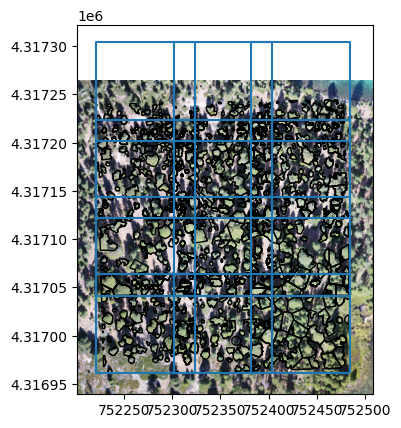

<Axes: >

In [8]:
treecrown_detections.plot(
    raster_file="/ofo-share/repos-amritha/tree-detection-framework/data/emerald-point-ortho/ortho.tif"
)